In [1]:
import kagglehub
input_path = kagglehub.dataset_download('rmisra/news-headlines-dataset-for-sarcasm-detection')

In [ ]:
import os, re
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
%matplotlib inline

In [ ]:
print(os.listdir(input_path))

['Sarcasm_Headlines_Dataset_v2.json', 'Sarcasm_Headlines_Dataset.json']


In [ ]:
df = pd.read_json(f'{input_path}/Sarcasm_Headlines_Dataset.json', lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
df = df[['headline','is_sarcastic']]
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


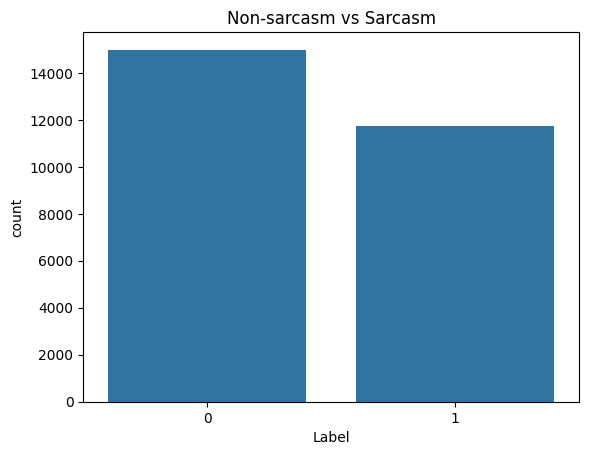

In [ ]:
sns.countplot(x ='is_sarcastic', data = df)
plt.xlabel('Label')
plt.title('Non-sarcasm vs Sarcasm')
plt.show()

In [ ]:
df['headline'] = df['headline'].apply(lambda x: x.lower())
df['headline'] = df['headline'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [ ]:
for idx,row in df.iterrows():
    row[0] = row[0].replace('rt',' ')

max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['headline'].values)
X = tokenizer.texts_to_sequences(df['headline'].values)
X = pad_sequences(X)

<ipython-input-9-c03c758310a7>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[0] = row[0].replace('rt',' ')
<ipython-input-9-c03c758310a7>:2: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row[0] = row[0].replace('rt',' ')


In [ ]:
Y = pd.get_dummies(df['is_sarcastic']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(17895, 29) (17895, 2)
(8814, 29) (8814, 2)


In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 25, batch_size=batch_size, verbose = 2)

Epoch 1/25


In [ ]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

229/229 - 5s - 20ms/step - accuracy: 0.8153 - loss: 0.9745
score: 0.97
acc: 0.82


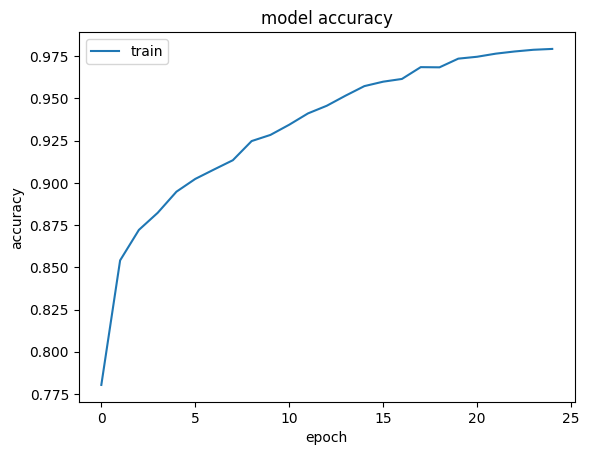

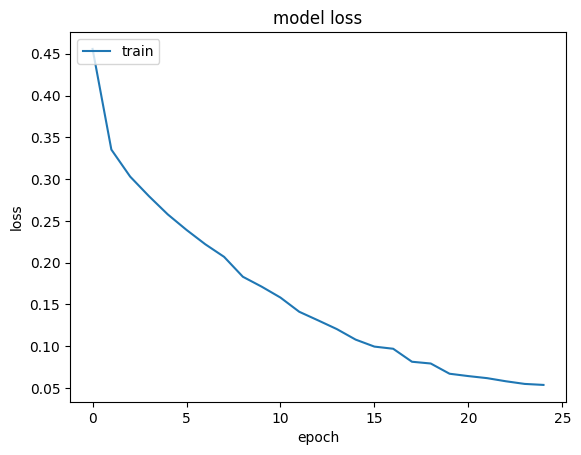

<Figure size 640x480 with 0 Axes>

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [ ]:
pos_cnt = neg_cnt = pos_correct = neg_correct = 0

for x, (x_val, y_val) in enumerate(zip(X_validate, Y_validate)):
    prediction = model.predict(x_val.reshape(1, X_test.shape[1]), batch_size=1, verbose=0)[0]
    predicted_label = np.argmax(prediction)
    true_label = np.argmax(y_val)

    if true_label == 1:
        pos_cnt += 1
        pos_correct += (predicted_label == 1)
    else:
        neg_cnt += 1
        neg_correct += (predicted_label == 0)

sarcasm_acc = (pos_correct / pos_cnt) * 100 if pos_cnt else 0
nonsarcasm_acc = (neg_correct / neg_cnt) * 100 if neg_cnt else 0

print(f"Sarcasm_acc: {sarcasm_acc:.2f}%")
print(f"Non-Sarcasm_acc: {nonsarcasm_acc:.2f}%")

1/1 - 0s - 419ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 41ms/step
1/1 - 0s - 57ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 39ms/step
1/1 - 0s - 42ms/step
1/1 - 0s - 39ms/step
1/1 - 0s - 45ms/step
1/1 - 0s - 39ms/step
1/1 - 0s - 38ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 43ms/step
1/1 - 0s - 39ms/step
1/1 - 0s - 52ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 42ms/step
1/1 - 0s - 45ms/step
1/1 - 0s - 69ms/step
1/1 - 0s - 68ms/step
1/1 - 0s - 66ms/step
1/1 - 0s - 61ms/step
1/1 - 0s - 80ms/step
1/1 - 0s - 62ms/step
1/1 - 0s - 58ms/step
1/1 - 0s - 63ms/step
1/1 - 0s - 62ms/step
1/1 - 0s - 62ms/step
1/1 - 0s - 60ms/step
1/1 - 0s - 68ms/step
1/1 - 0s - 65ms/step
1/1 - 0s - 65ms/step
1/1 - 0s - 70ms/step
1/1 - 0s - 65ms/step
1/1 - 0s - 71ms/step
1/1 - 0s - 39ms/step
1/1 - 0s - 39ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 42ms/step
1/1 - 0s - 45ms/step
1/1 - 0s - 39ms/step
1/1 - 0s - 39ms/step
1/1 - 0s - 43ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 42ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 4

In [ ]:
headline = ['GTA VI Delayed Until Developers Get Grades Up']
headline = tokenizer.texts_to_sequences(headline)
headline = pad_sequences(headline, maxlen=29, dtype='int32', value=0)

sentiment = model.predict(headline,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("Non-sarcastic")
elif (np.argmax(sentiment) == 1):
    print("Sarcasm")

1/1 - 0s - 42ms/step
Sarcasm


In [ ]:
#Save the model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.weights.h5")